In [1]:
import glog
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
import torch.nn.functional as F
from pytorch_lightning import seed_everything


sys.path.append('../../..')

import xfinai_config
from data_layer.base_dataset import FuturesDatasetRecurrent
from utils import path_wrapper, plotter

In [2]:
seed = 416
seed_everything(seed)

future_index= 'ic'

params = {
    "epochs":10,
    "batch_size": 128,
    "hidden_size": 128,
    "seq_length": 32,
    "weight_decay": 0.03699014272607559,
    "num_layers": 1,
    "learning_rate": 0.005264079267383521,
    "dropout_prob": 0.0049846528896436
}

I0405 18:48:05.893157 16520 seed.py:69] Global seed set to 416


In [3]:
# Load data
train_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_train_data.pkl")
val_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_val_data.pkl")
test_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_test_data.pkl")

### 1 Define AttnGRU Model

In [4]:
class EncoderGRU(nn.Module):
    def __init__(self, params):
        super(EncoderGRU, self).__init__()

        self.name = 'EncoderGRU'
        self.input_size = params["input_size"]
        self.batch_size =  params["batch_size"]
        self.output_size = params["output_size"]
        self.num_layers = params["num_layers"]
        self.hidden_size = params["hidden_size"]
        self.device = params["device"]
        self.dropout_prob = params["dropout_prob"]
        self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers,
                          batch_first=True, dropout=self.dropout_prob)
        self.dropout = nn.Dropout(self.dropout_prob)


    def forward(self, x, hidden):
        x = x.view(self.batch_size, 1, -1)
        x, hidden = self.gru(x, hidden)
        return x, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [5]:
class AttnDecoderGRU(nn.Module):
    def __init__(self, params):
        super(AttnDecoderGRU, self).__init__()
        self.name = 'DecoderGRU'
        self.input_size = params["input_size"]
        self.batch_size =  params["batch_size"]
        self.output_size = params["output_size"]
        self.num_layers = params["num_layers"]
        self.seq_length =  params["seq_length"]
        self.hidden_size = params["hidden_size"]
        self.device = params["device"]
        self.dropout_prob = params["dropout_prob"]

        self.attn = nn.Linear(self.hidden_size + self.output_size, self.seq_length)
        self.attn_combine = nn.Linear(self.hidden_size + self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_prob)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, last_input, hidden, encoder_outputs):

        attn_weights = F.softmax(
            self.attn(torch.cat((last_input, hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs.transpose(0,1)).squeeze(1)
        output = torch.cat((last_input, attn_applied), 1)
        output = self.attn_combine(output).unsqueeze(1)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output[:,0,:], hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

### 2 Create Training Func

In [6]:
def inference(x_batch, params, encoder, decoder):
    encoder_outputs = torch.zeros(params['seq_length'], params['batch_size'], encoder.hidden_size, device=device)

    for time_step in range(params['seq_length']):
        x_time_step = x_batch[:,time_step,:] 
        encoder_hidden = encoder.init_hidden()
        encoder_output, encoder_hidden = encoder(x_time_step, encoder_hidden)
        encoder_outputs[time_step] = encoder_output[:,0,:]

    decoder_input = torch.zeros(params['batch_size'],1, device=encoder.device)
    decoder_hidden = encoder_hidden

    for time_step in range(params['seq_length']):
        output, hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_input = output

    return output, attn_weights

In [7]:
def train(train_data_loader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, params):

    # Set to train mode
    encoder.train()
    decoder.train()
    running_train_loss = 0.0
    attn_weights_list = []
    
    # Begin training
    for idx, (x_batch, y_batch) in enumerate(train_data_loader):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Convert to Tensors
        x_batch = x_batch.float().to(encoder.device)
        y_batch = y_batch.float().to(encoder.device)
        

        # Make prediction
        y_pred, attn_weights = inference(x_batch, params, encoder, decoder)

        # Calculate loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        running_train_loss += loss.item()
        attn_weights_list.append(attn_weights)
        
        encoder_optimizer.step()
        decoder_optimizer.step()


    train_loss_average = running_train_loss / len(train_data_loader)
    return encoder, decoder, train_loss_average

In [8]:
def validate(val_data_loader,  encoder, decoder, criterion, params):
    # Set to eval mode
    encoder.eval()
    decoder.eval()

    running_val_loss = 0.0
    attn_weights_list = []

    with torch.no_grad():

        for idx, (x_batch, y_batch) in enumerate(val_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(encoder.device)
            y_batch = y_batch.float().to(encoder.device)

            # Make prediction
            y_pred, attn_weights = inference(x_batch, params, encoder, decoder)
            
            val_loss = criterion(y_pred, y_batch)
            running_val_loss += val_loss.item()
            attn_weights_list.append(attn_weights)
            
    val_loss_average = running_val_loss / len(val_data_loader)
    return val_loss_average

In [9]:
def eval_model(encoder, decoder, dataloader, data_set_name, future_name, params):
    
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])

        for idx, (x_batch, y_batch) in enumerate(dataloader):
            # Convert to Tensors
            x_batch = x_batch.float().to(encoder.device)
            y_batch = y_batch.float().to(encoder.device)

            # Make prediction
            y_pred, attn_weights = inference(x_batch, params, encoder, decoder)
            
            y_real_list = np.append(y_real_list, y_batch.squeeze(1).cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.squeeze(1).cpu().numpy())

    plt.figure(figsize=[15, 3], dpi=100)
    plt.plot(y_real_list, label=f'{data_set_name}_real')
    plt.plot(y_pred_list, label=f'{data_set_name}_pred')
    plt.legend()
    plt.title(f"Inference On {data_set_name} Set - {encoder.name} {future_name}")
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.subplots_adjust(bottom=0.15)

#     result_dir = path_wrapper.wrap_path(f"{xfinai_config.inference_result_path}/{future_name}/{model.name}")
#     plt.savefig(f"{result_dir}/{data_set_name}.png")
    

def save_model(model, future_name):
    dir_path = path_wrapper.wrap_path(f"{xfinai_config.model_save_path}/{future_name}")
    save_path = f"{dir_path}/{model.name}.pth"
    glog.info(f"Starting save model state, save_path: {save_path}")
    torch.save(model.state_dict(), save_path)

### 3 Run Training

In [10]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create dataset & data loader
train_dataset = FuturesDatasetRecurrent(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
val_dataset = FuturesDatasetRecurrent(data=val_data, label=xfinai_config.label, seq_length=params['seq_length'])
test_dataset = FuturesDatasetRecurrent(data=test_data, label=xfinai_config.label, seq_length=params['seq_length'])
train_loader = DataLoader(dataset=train_dataset, **xfinai_config.data_loader_config,
                          batch_size=params['batch_size'])
val_loader = DataLoader(dataset=val_dataset, **xfinai_config.data_loader_config,
                        batch_size=params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, **xfinai_config.data_loader_config,
                         batch_size=params['batch_size'])

In [11]:
params.update({"input_size": len(train_dataset.features_list),
              "device": device,
              "output_size": xfinai_config.model_config['GRU']['output_size']})
# create model instance
encoder = EncoderGRU(params).to(device)
decoder = AttnDecoderGRU(params).to(device)

criterion = nn.MSELoss()

encoder_optimizer = optim.AdamW(encoder.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])
decoder_optimizer = optim.AdamW(decoder.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])

epochs = params['epochs']

print(encoder)
print(decoder)

train_losses = []
val_losses = []
# train the model
glog.info(f"Start Training Model")

for epoch in range(epochs):
    trained_encoder, trained_decoder, train_score = train(train_data_loader=train_loader, encoder=encoder, decoder=decoder, criterion=criterion,
                                       encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                                       params=params)
    val_score = validate(val_data_loader=val_loader, encoder=trained_encoder, decoder=trained_decoder, criterion=criterion, params=params)

    # report intermediate result
    print(f"Epoch :{epoch} train_score {train_score} val_score {val_score}")
        
    train_losses.append(train_score)
    val_losses.append(val_score)
    
glog.info(f"End Training Model")

W0405 18:48:07.504157 16520 warnings.py:109] D:\Anaconda\envs\nni\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0049846528896436 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "

I0405 18:48:10.148091 16520 369672594.py:25] Start Training Model


EncoderGRU(
  (gru): GRU(27, 128, batch_first=True, dropout=0.0049846528896436)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
)
AttnDecoderGRU(
  (attn): Linear(in_features=129, out_features=32, bias=True)
  (attn_combine): Linear(in_features=129, out_features=128, bias=True)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
  (gru): GRU(128, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Epoch :0 train_score 0.004429091785277705 val_score 0.0005503765056154838
Epoch :1 train_score 0.00017921526262268473 val_score 0.00032492582556044097
Epoch :2 train_score 9.557750523916703e-05 val_score 7.781857220834354e-05
Epoch :3 train_score 2.9484708800607354e-05 val_score 0.00023003632441032096
Epoch :4 train_score 4.58493238576401e-05 val_score 0.00020999234038754366
Epoch :5 train_score 3.085083460194125e-05 val_score 8.578231226190263e-05
Epoch :6 train_score 1.4353781520932379e-05 val_score 2.202954069137999e-05
Epoch :7 train_score 

I0405 18:51:15.952863 16520 369672594.py:39] End Training Model


Epoch :9 train_score 2.6001979823117185e-06 val_score 1.0454070135031207e-05


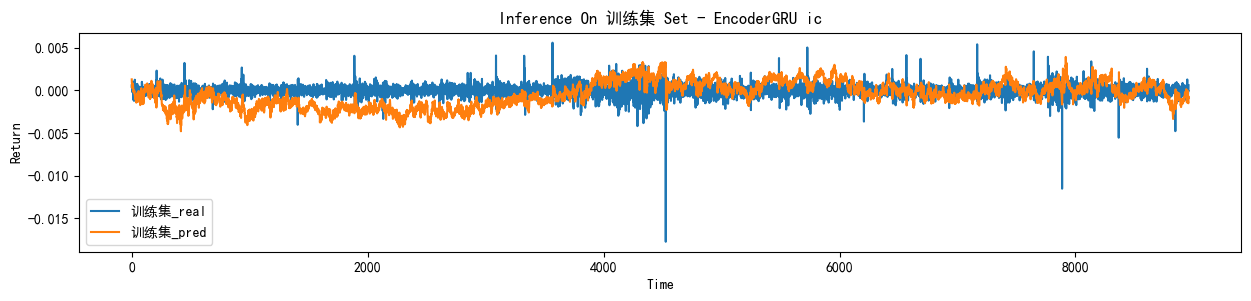

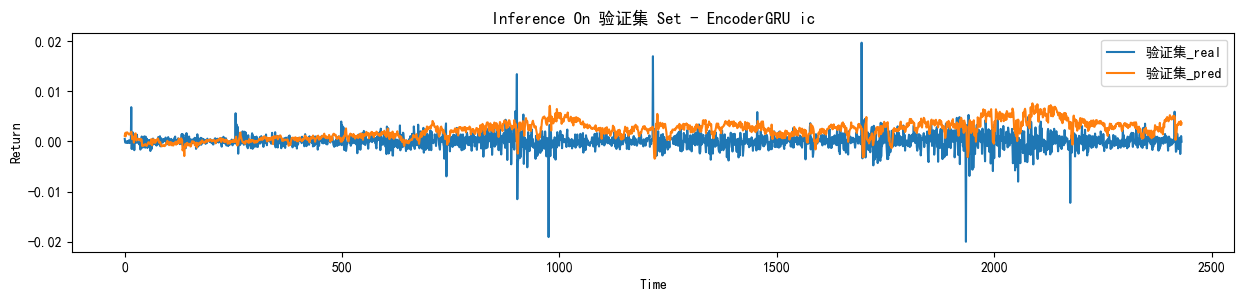

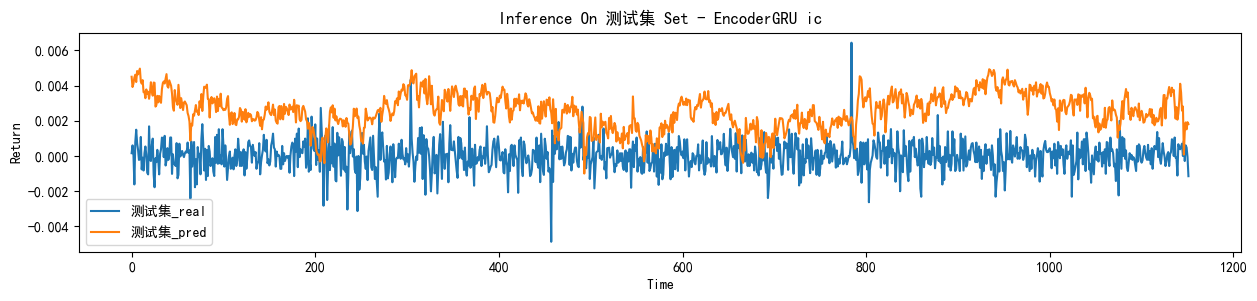

In [12]:
# eval model on 3 datasets
for dataloader, data_set_name in zip([train_loader, val_loader, test_loader],
                                     ['训练集', '验证集', '测试集']):
    eval_model(encoder=trained_encoder, decoder=trained_decoder, dataloader=dataloader, data_set_name=data_set_name,
               future_name=future_index, params=params)
    